In [1]:
from typing import Dict, Optional
import os
import dotenv

import mdtraj as md
import numpy as np
import pyemma
from scipy.spatial import distance
from statsmodels.tsa import stattools
import matplotlib.pyplot as plt
import lovelyplots

plt.style.use("ipynb")

from jamun.metrics._ramachandran import compute_JS_divergence_of_ramachandran, num_dihedrals
from jamun import utils

import utils as analysis_utils

/homefs/home/daigavaa/miniforge3/envs/jamun-extras/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'create_dataset_from_pdb' from 'jamun.data._utils' (/homefs/home/daigavaa/jamun/src/jamun/data/_utils.py)

### Environment Variables

These are needed to load reference MD trajectories for comparison.

In [2]:
results_dir = "/homefs/home/daigavaa/jamun/analysis_results"
print(f"JAMUN_DATA_PATH: {JAMUN_DATA_PATH}")
print(f"JAMUN_ROOT_PATH: {JAMUN_ROOT_PATH}")

JAMUN_DATA_PATH: /data/bucket/kleinhej/
JAMUN_ROOT_PATH: /data/bucket/kleinhej/jamun-runs/


### JAMUN W&B Run Paths
Specify the Weights and Biases run paths for JAMUN sampling runs:

In [3]:
# Uncapped 2AA
# wandb_sample_run_paths = [
#     "prescient-design/jamun/dss1dnyt",
#     "prescient-design/jamun/jls6fodw",
# ]

# Uncapped 4AA
wandb_sample_run_paths = [
    "prescient-design/jamun/xv2dsan8",
    "prescient-design/jamun/a8fukafx",
    "prescient-design/jamun/odb1bs62",
    "prescient-design/jamun/5dklwb4r",
]

Specify which peptides to analyze:

In [4]:
filter_codes = ["FAFG", "IDRL"]
# filter_codes = None

### Load All Trajectories

In [5]:
run_paths = [analysis_utils.get_run_path_for_wandb_run(wandb_run_path) for wandb_run_path in wandb_sample_run_paths]
JAMUN_trajs = analysis_utils.get_JAMUN_trajectories(run_paths, filter_codes=filter_codes)
JAMUN_trajs

[2025-01-20 00:04:33,243][jamun][INFO] - Loading checkpoint corresponding to wandb run dulcet-wildflower-292 at https://genentech.wandb.io/prescient-design/jamun/runs/xv2dsan8
[2025-01-20 00:04:33,403][jamun][INFO] - Loading checkpoint corresponding to wandb run silver-wood-291 at https://genentech.wandb.io/prescient-design/jamun/runs/a8fukafx
[2025-01-20 00:04:33,568][jamun][INFO] - Loading checkpoint corresponding to wandb run light-cherry-290 at https://genentech.wandb.io/prescient-design/jamun/runs/odb1bs62
[2025-01-20 00:04:33,725][jamun][INFO] - Loading checkpoint corresponding to wandb run fast-serenity-289 at https://genentech.wandb.io/prescient-design/jamun/runs/5dklwb4r
[2025-01-20 00:04:33,733][jamun][INFO] - Found peptides ['ICKK', 'IDRL', 'IHLA', 'IKFR', 'IKII', 'IKSF', 'ILLY', 'IMYP', 'ISSK', 'ITVV', 'IVAK', 'IVNE', 'KADL', 'KAEG'] in run /data/bucket/kleinhej/jamun-runs/outputs/sample/dev/runs/52710300c5520ca8503d7d47
[2025-01-20 00:04:33,774][jamun][INFO] - Found peptid

100%|██████████| 164/164 [00:36<00:00,  4.47it/s]


{'IDRL': <mdtraj.Trajectory with 100000 frames, 36 atoms, 4 residues, without unitcells at 0x7f14b0b2b580>,
 'FAFG': <mdtraj.Trajectory with 100000 frames, 32 atoms, 4 residues, without unitcells at 0x7f14b0b29ed0>}

In [6]:
Timewarp_trajs = analysis_utils.get_Timewarp_trajectories(
    JAMUN_DATA_PATH, peptide_type="4AA", filter_codes=list(JAMUN_trajs.keys()), split="test",
)
Timewarp_trajs

Creating datasets:   0%|          | 0/2 [00:00<?, ?it/s]

Creating datasets:  50%|█████     | 1/2 [00:03<00:03,  3.92s/it]

<mdtraj.Trajectory with 499001 frames, 32 atoms, 4 residues, without unitcells> [ 0  4  6  9 10 12 14 16 18 20 21 22 24 26 30 31 32 34 36 39 40 42 44 46
 48 50 51 52 54 57 58 59]


Creating datasets: 100%|██████████| 2/2 [00:10<00:00,  5.42s/it]

<mdtraj.Trajectory with 500000 frames, 36 atoms, 4 residues, without unitcells> [ 0  4  6  8 12 15 19 20 21 23 25 28 29 30 31 32 33 35 37 40 43 46 48 49
 52 55 56 57 59 61 64 66 70 74 75 76]


{'FAFG': <mdtraj.Trajectory with 499001 frames, 32 atoms, 4 residues, without unitcells at 0x7f1471a2e1a0>,
 'IDRL': <mdtraj.Trajectory with 500000 frames, 36 atoms, 4 residues, without unitcells at 0x7f1471879390>}

In [7]:
MDGen_trajs = analysis_utils.get_MDGen_trajectories(
    JAMUN_DATA_PATH, filter_codes=filter_codes, split="val",
)
MDGen_trajs

Creating datasets: 0it [00:00, ?it/s]


{}

In [8]:
# These are our capped datasets.
# OpenMM_trajs = analysis_utils.get_OpenMM_trajectories(JAMUN_DATA_PATH, filter_codes=list(JAMUN_trajs.keys()))
# OpenMM_trajs

In [9]:
# TBG_trajs = get_TBG_trajectories("tbg_samples")

In [ ]:
raise ValueError("")

ValueError: 

### Ramachandran Plots

In [11]:
def plot_ramachandran_contour(traj: md.Trajectory, dihedral_index: int, ax: Optional[plt.Axes] = None) -> plt.Axes:
    """Plots the Ramachandran contour plot of a trajectory."""

    if ax is None:
        _, ax = plt.subplots(figsize=(10, 10))

    _, phi = md.compute_phi(traj)
    _, psi = md.compute_psi(traj)
    H, xedges, yedges = np.histogram2d(
        phi.T[dihedral_index], psi.T[dihedral_index], bins=np.linspace(-np.pi, np.pi, 50)
    )
    pmf = -np.log(H.T) + np.max(np.log(H.T))

    im = ax.contourf(xedges[:-1], yedges[:-1], pmf, cmap="viridis", levels=50)
    contour = ax.contour(xedges[:-1], yedges[:-1], pmf, colors="white", linestyles="solid", levels=30, linewidths=0.25)

    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("$\phi$")
    ax.set_ylabel("$\psi$")

    tick_eps = 0.1
    ticks = [-np.pi + tick_eps, -np.pi / 2, 0, np.pi / 2, np.pi - tick_eps]
    tick_labels = ["$-\pi$", "$-\pi/2$", "$0$", "$\pi/2$", "$\pi$"]
    ax.set_xticks(ticks, tick_labels)
    ax.set_yticks(ticks, tick_labels)

    return ax


def format_for_plot(peptide: str) -> str:
    return "-".join([utils.convert_to_three_letter_code(aa) for aa in peptide])

n_dihedrals 3
label_offset 0.5


/tmp/ipykernel_3081605/2092272358.py:12: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(H.T) + np.max(np.log(H.T))
/tmp/ipykernel_3081605/2092272358.py:12: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(H.T) + np.max(np.log(H.T))
/tmp/ipykernel_3081605/2092272358.py:12: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(H.T) + np.max(np.log(H.T))
/tmp/ipykernel_3081605/2092272358.py:12: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(H.T) + np.max(np.log(H.T))
/tmp/ipykernel_3081605/2092272358.py:12: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(H.T) + np.max(np.log(H.T))
/tmp/ipykernel_3081605/2092272358.py:12: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(H.T) + np.max(np.log(H.T))
/tmp/ipykernel_3081605/2092272358.py:12: RuntimeWarning: divide by zero encountered in log
  pmf = -np.log(H.T) + np.max(np.log(H.T))
/tmp/ipykernel_3081605/2092272358.py:12: RuntimeWarning: divid

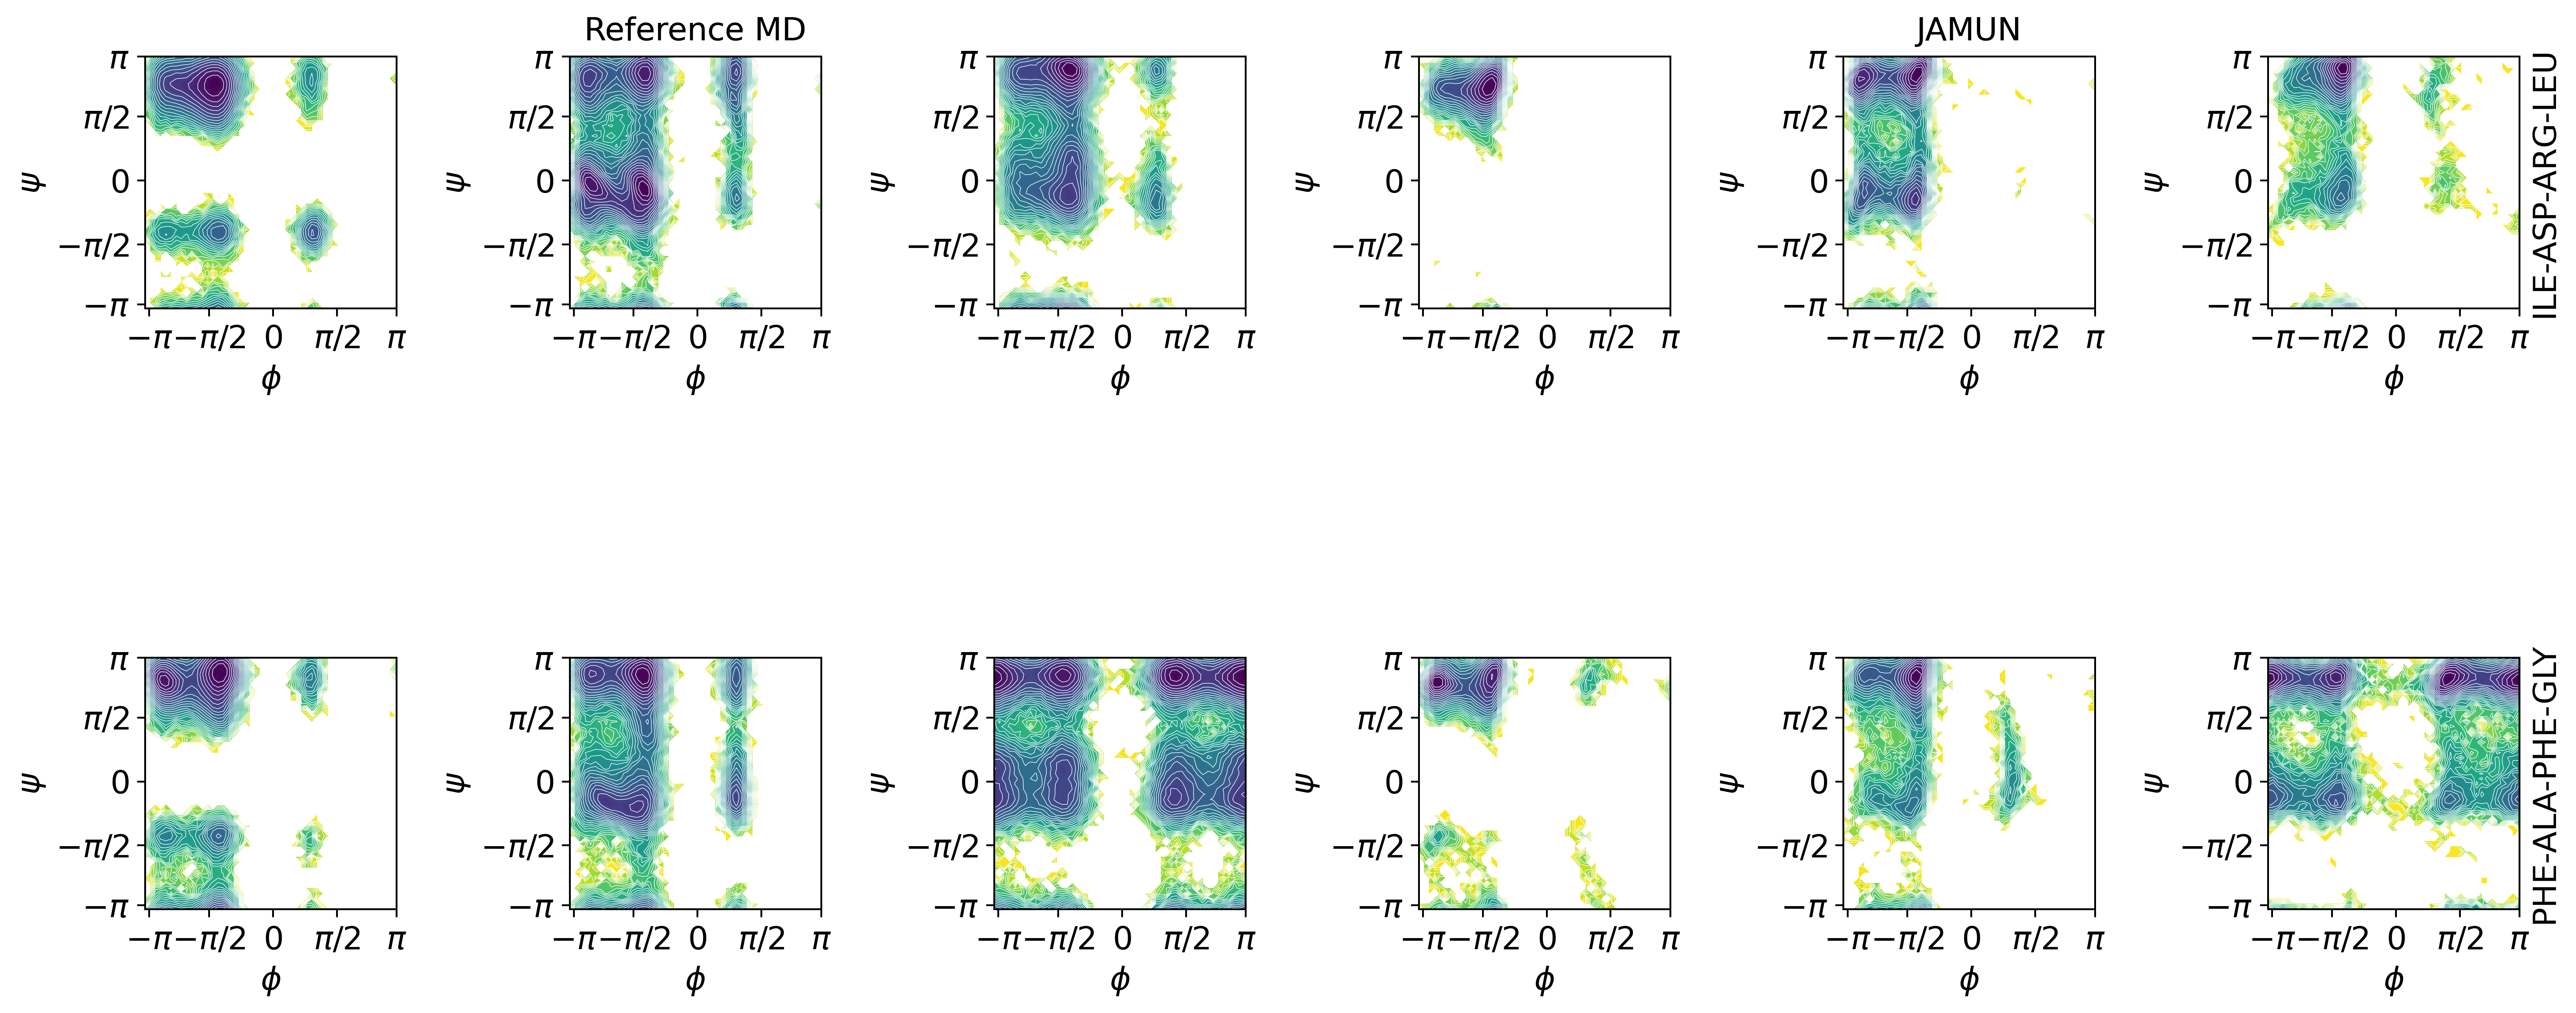

In [12]:
n_dihedrals = num_dihedrals(next(iter(JAMUN_trajs.values())))
print("n_dihedrals", n_dihedrals)
if n_dihedrals % 2 == 0:
    label_offset = 1.0
else:
    label_offset = 0.5
print("label_offset", label_offset)

fig, axs = plt.subplots(len(JAMUN_trajs), 2 * n_dihedrals, figsize=(16, 8), squeeze=False)
for i, peptide in enumerate(JAMUN_trajs):
    for j in range(n_dihedrals):
        plot_ramachandran_contour(Timewarp_trajs[peptide], j, axs[i, j])
        plot_ramachandran_contour(JAMUN_trajs[peptide], j, axs[i, j + n_dihedrals])

    # Add labels.
    axs[0, n_dihedrals // 2].text(
        label_offset,
        1.1,
        "Reference MD",
        horizontalalignment="center",
        verticalalignment="center",
        transform=axs[0, n_dihedrals // 2].transAxes,
    )
    axs[0, n_dihedrals // 2 + n_dihedrals].text(
        label_offset,
        1.1,
        "JAMUN",
        horizontalalignment="center",
        verticalalignment="center",
        transform=axs[0, n_dihedrals // 2 + n_dihedrals].transAxes,
    )
    axs[i, -1].text(
        1.1,
        0.5,
        format_for_plot(peptide),
        rotation=90,
        verticalalignment="center",
        horizontalalignment="center",
        transform=axs[i, -1].transAxes,
    )

plt.tight_layout()
plt.show()

### Feature Histograms

/homefs/home/daigavaa/miniforge3/envs/jamun-extras/lib/python3.10/site-packages/pyemma/coordinates/data/featurization/angles.py:211: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(valid.values())
/homefs/home/daigavaa/miniforge3/envs/jamun-extras/lib/python3.10/site-packages/pyemma/coordinates/data/featurization/angles.py:211: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(valid.values())
/homefs/home/daigavaa/miniforge3/envs/jamun-extras/lib/python3.10/site-packages/pyemma/coordinates/data/featurization/angles.py:211: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support

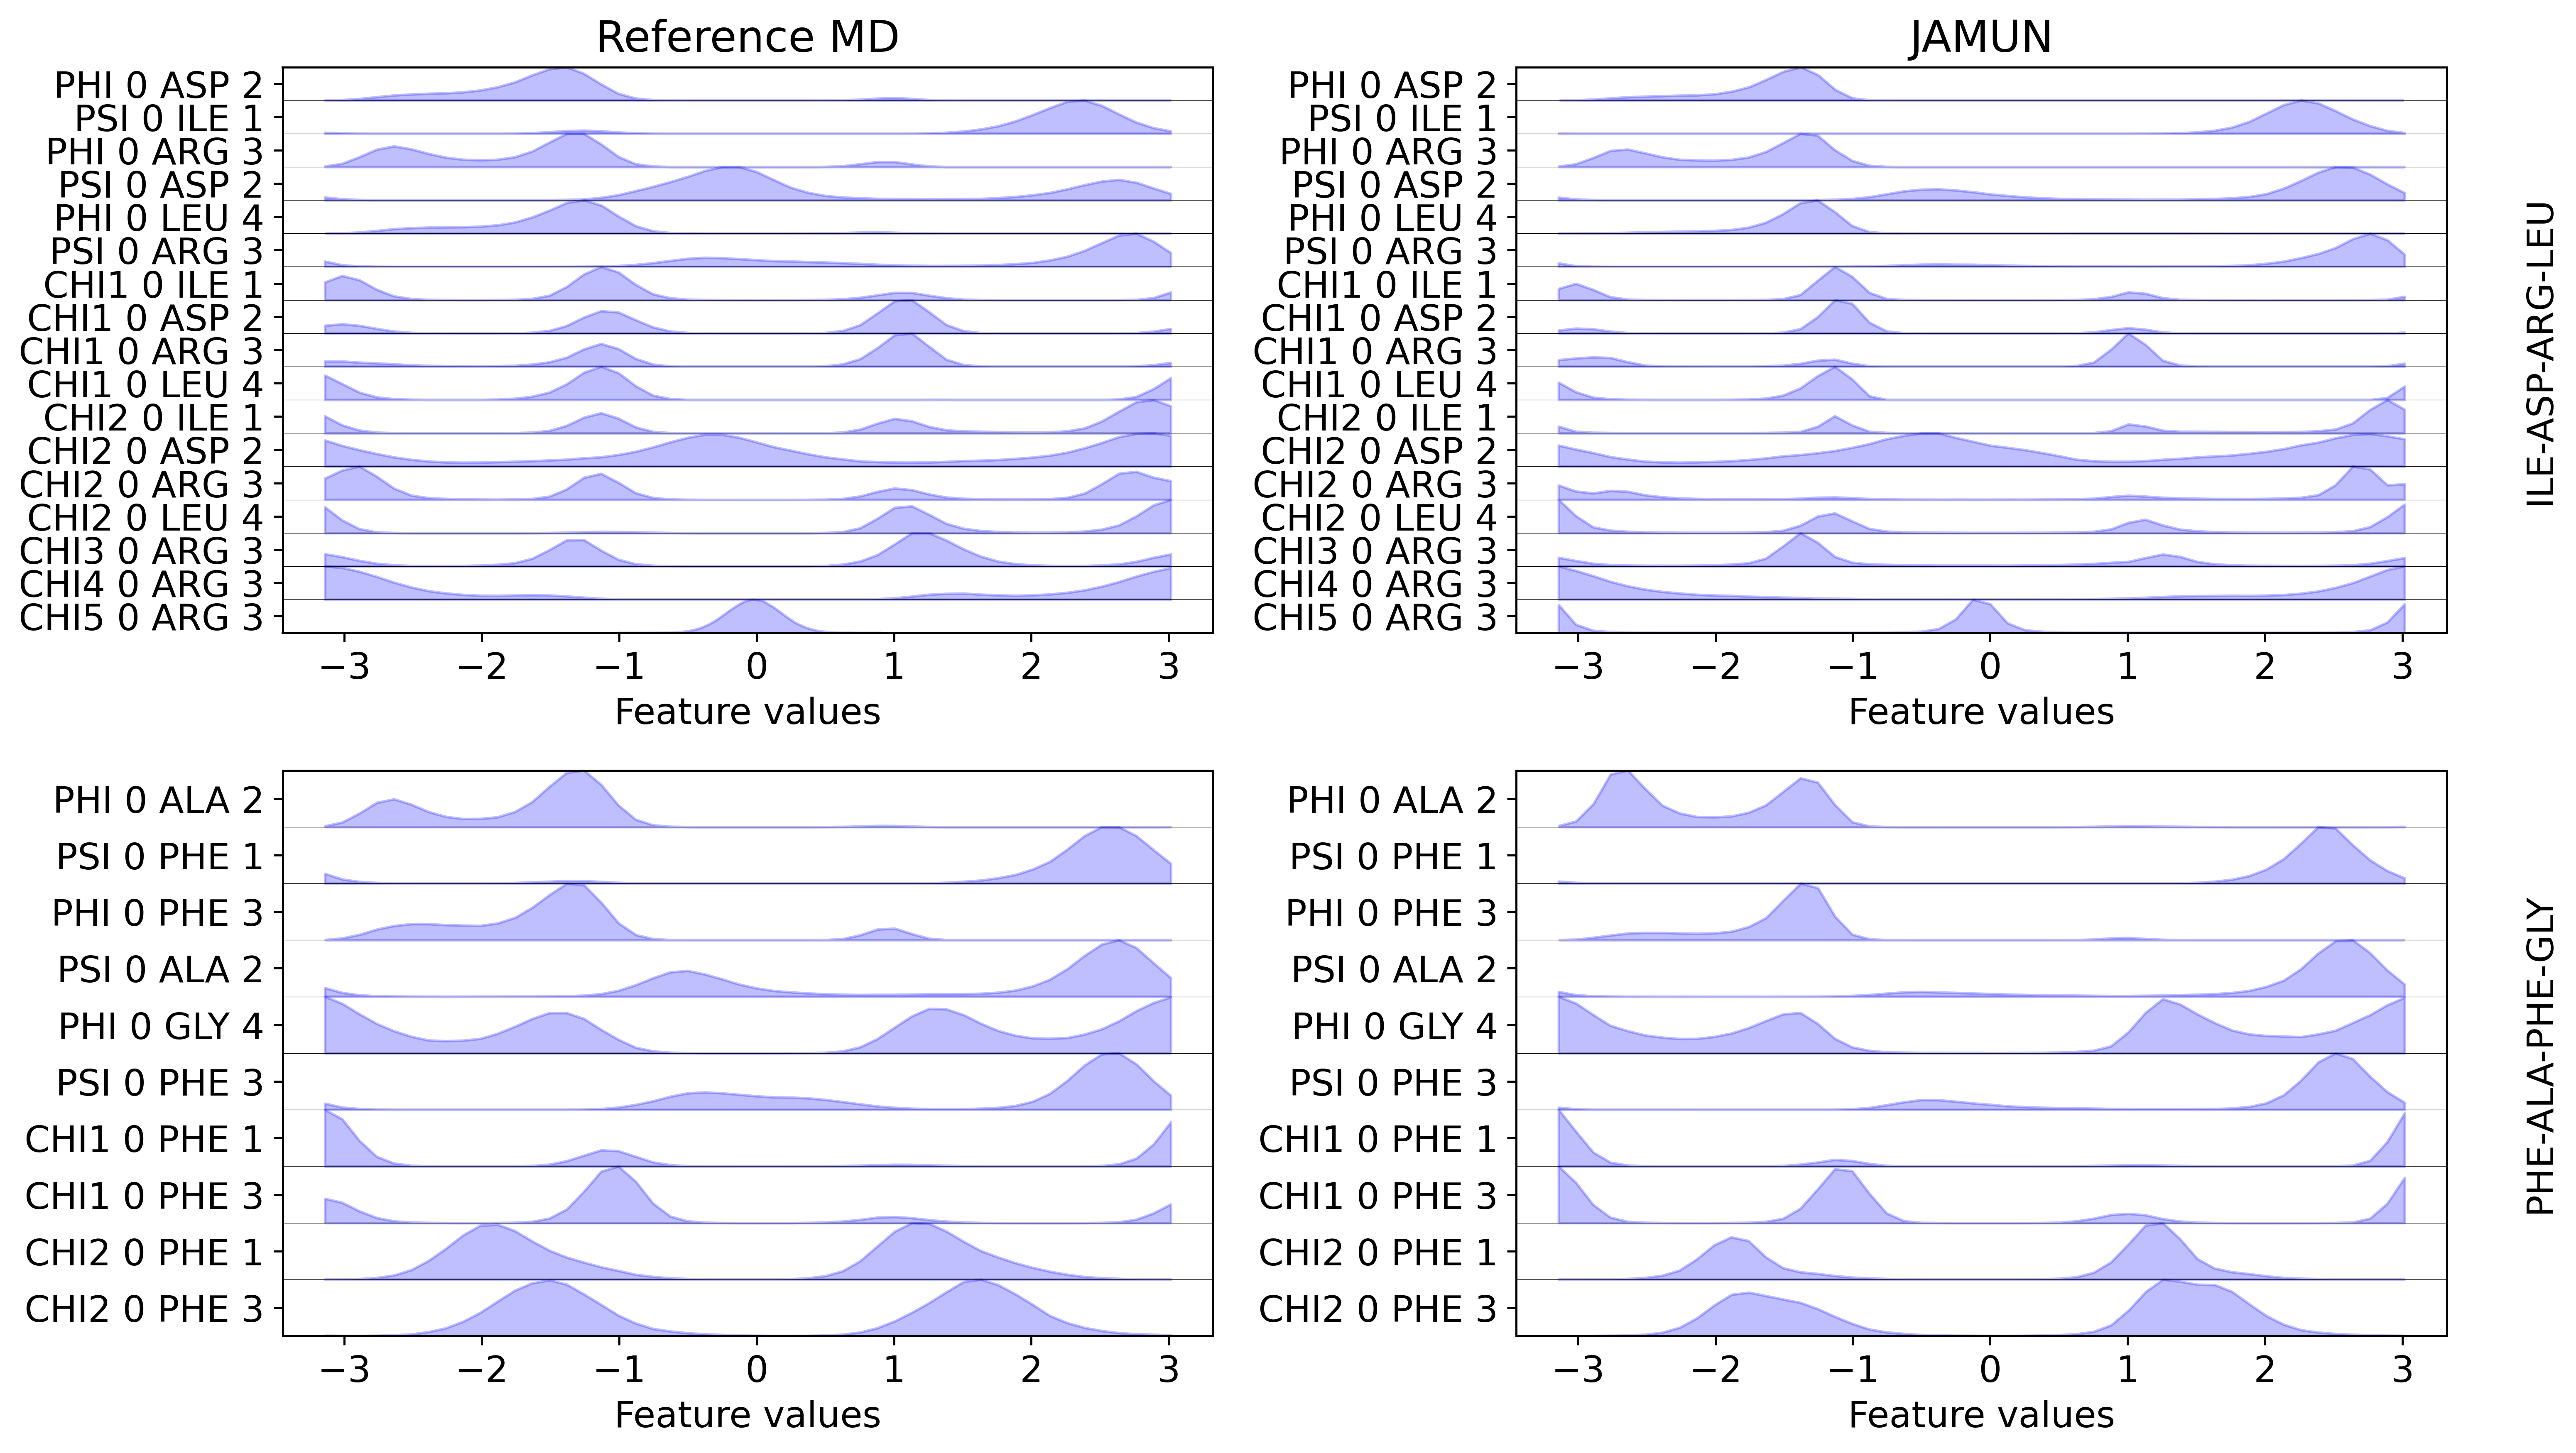

In [13]:
fig, axs = plt.subplots(nrows=len(JAMUN_trajs), ncols=2, figsize=(14, 8), squeeze=False)
for i, peptide in enumerate(JAMUN_trajs):
    Timewarp_feat, Timewarp_featurized_traj = analysis_utils.featurize_trajectory(Timewarp_trajs[peptide])
    pyemma.plots.plot_feature_histograms(
        Timewarp_featurized_traj, feature_labels=Timewarp_feat.describe(), ax=axs[i, 0]
    )

    JAMUN_feat, JAMUN_featurized_traj = analysis_utils.featurize_trajectory(JAMUN_trajs[peptide])
    pyemma.plots.plot_feature_histograms(JAMUN_featurized_traj, feature_labels=JAMUN_feat.describe(), ax=axs[i, 1])

    axs[i, -1].text(
        1.1,
        0.5,
        format_for_plot(peptide),
        rotation=90,
        verticalalignment="center",
        horizontalalignment="center",
        transform=axs[i, -1].transAxes,
    )

axs[0, 0].set_title("Reference MD")
axs[0, 1].set_title("JAMUN")
plt.tight_layout()

In [14]:
for i, peptide in enumerate(JAMUN_trajs):
    print("peptide", peptide)

    Timewarp_feat, Timewarp_featurized_traj = analysis_utils.featurize_trajectory(Timewarp_trajs[peptide])
    JAMUN_feat, JAMUN_featurized_traj = analysis_utils.featurize_trajectory(JAMUN_trajs[peptide])

    for j, feat in enumerate(Timewarp_feat.describe()):
        Timewarp_p = np.histogram(Timewarp_featurized_traj[:, j], range=(-np.pi, np.pi), bins=100)[0]
        JAMUN_p = np.histogram(JAMUN_featurized_traj[:, j], range=(-np.pi, np.pi), bins=100)[0]
        print(feat, "JSD:", distance.jensenshannon(Timewarp_p, JAMUN_p))

peptide IDRL


/homefs/home/daigavaa/miniforge3/envs/jamun-extras/lib/python3.10/site-packages/pyemma/coordinates/data/featurization/angles.py:211: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(valid.values())


PHI 0 ASP 2 JSD: 0.1414399181841636
PSI 0 ILE 1 JSD: 0.1660329006287216
PHI 0 ARG 3 JSD: 0.1523774895165957
PSI 0 ASP 2 JSD: 0.2741724511780696
PHI 0 LEU 4 JSD: 0.174770344349615
PSI 0 ARG 3 JSD: 0.19845061615925602
CHI1 0 ILE 1 JSD: 0.15878994264380322
CHI1 0 ASP 2 JSD: 0.3532168019043034
CHI1 0 ARG 3 JSD: 0.26236986077917984
CHI1 0 LEU 4 JSD: 0.1793463368283413
CHI2 0 ILE 1 JSD: 0.18315898884067278
CHI2 0 ASP 2 JSD: 0.08812659918033014
CHI2 0 ARG 3 JSD: 0.2787765780105199
CHI2 0 LEU 4 JSD: 0.3473512345227432
CHI3 0 ARG 3 JSD: 0.23657613145726067
CHI4 0 ARG 3 JSD: 0.08849958624395911
CHI5 0 ARG 3 JSD: 0.46703778811497787
peptide FAFG
PHI 0 ALA 2 JSD: 0.18843851690562244
PSI 0 PHE 1 JSD: 0.17481668433722017
PHI 0 PHE 3 JSD: 0.1570434130071412
PSI 0 ALA 2 JSD: 0.20928298782304608
PHI 0 GLY 4 JSD: 0.06510226995831882
PSI 0 PHE 3 JSD: 0.15783592722059875
CHI1 0 PHE 1 JSD: 0.16176765090710563
CHI1 0 PHE 3 JSD: 0.16410672171509116
CHI2 0 PHE 1 JSD: 0.15879958530022845
CHI2 0 PHE 3 JSD: 0.12

### TICA Analysis

In [15]:
def compute_TICA_stats(traj_tica: np.ndarray, ref_tica: np.ndarray) -> Dict[str, float]:
    """Compute stats on TICA projections of trajectories."""
    tica_0_min = min(ref_tica[:, 0].min(), traj_tica[:, 0].min())
    tica_0_max = max(ref_tica[:, 0].max(), traj_tica[:, 0].max())

    tica_1_min = min(ref_tica[:, 1].min(), traj_tica[:, 1].min())
    tica_1_max = max(ref_tica[:, 1].max(), traj_tica[:, 1].max())

    ref_p = np.histogram(ref_tica[:, 0], range=(tica_0_min, tica_0_max), bins=100)[0]
    traj_p = np.histogram(traj_tica[:, 0], range=(tica_0_min, tica_0_max), bins=100)[0]
    tica_0_jsd = distance.jensenshannon(ref_p, traj_p)

    ref_p = np.histogram2d(*ref_tica[:, :2].T, range=((tica_0_min, tica_0_max), (tica_1_min, tica_1_max)), bins=50)[0]
    traj_p = np.histogram2d(*traj_tica[:, :2].T, range=((tica_0_min, tica_0_max), (tica_1_min, tica_1_max)), bins=50)[0]
    tica_01_jsd = distance.jensenshannon(ref_p.flatten(), traj_p.flatten())

    return {
        "TICA-0 JSD": tica_0_jsd,
        "TICA-0,1 JSD": tica_01_jsd,
    }

In [16]:
# fig, axs = plt.subplots(nrows=len(JAMUN_trajs), ncols=2, figsize=(12, 6), squeeze=False)

# for i, peptide in enumerate(JAMUN_trajs):
#     print("peptide", peptide)

#     Timewarp_feat, Timewarp_featurized_traj = analysis_utils.featurize_trajectory(
#         Timewarp_trajs[peptide], cossin=True
#     )
#     JAMUN_feat, JAMUN_featurized_traj = analysis_utils.featurize_trajectory(
#         JAMUN_trajs[peptide], cossin=True
#     )

#     tica = pyemma.coordinates.tica(Timewarp_featurized_traj, lag=1000, kinetic_map=True)
#     Timewarp_tica = tica.transform(Timewarp_featurized_traj)
#     JAMUN_tica = tica.transform(JAMUN_featurized_traj)

#     # Compute stats.
#     tica_stats = compute_TICA_stats(JAMUN_tica, Timewarp_tica)
#     print(tica_stats["TICA-0 JSD"])
#     print(tica_stats["TICA-0,1 JSD"])

#     # Plot free energy.
#     pyemma.plots.plot_free_energy(Timewarp_tica[:, 0], Timewarp_tica[:, 1], cmap="plasma", ax=axs[i, 0])
#     axs[i, 0].set_title("Reference MD")

#     pyemma.plots.plot_free_energy(JAMUN_tica[:, 0], JAMUN_tica[:, 1], cmap="plasma", ax=axs[i, 1])
#     axs[i, 1].set_title("JAMUN")

#     axs[i, -1].text(
#         1.4,
#         0.5,
#         format_for_plot(peptide),
#         rotation=90,
#         verticalalignment="center",
#         horizontalalignment="center",
#         transform=axs[i, -1].transAxes,
#     )

# plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(nrows=len(JAMUN_trajs), ncols=1, figsize=(12, 6), squeeze=False)

for i, peptide in enumerate(JAMUN_trajs):
    print("peptide", peptide)

    Timewarp_feat, Timewarp_featurized_traj = analysis_utils.featurize_trajectory(
        Timewarp_trajs[peptide], cossin=True
    )
    JAMUN_feat, JAMUN_featurized_traj = analysis_utils.featurize_trajectory(
        JAMUN_trajs[peptide], cossin=True
    )

    tica = pyemma.coordinates.tica(Timewarp_featurized_traj, lag=1000, kinetic_map=True)
    Timewarp_tica = tica.transform(Timewarp_featurized_traj)
    JAMUN_tica = tica.transform(JAMUN_featurized_traj)

    nlag = 1000
    Timewarp_autocorr = stattools.acovf(Timewarp_tica[:, 0], nlag=nlag, adjusted=True, demean=False)
    JAMUN_autocorr = stattools.acovf(JAMUN_tica[:, 0], nlag=nlag, adjusted=True, demean=False)

    axs[i].plot(Timewarp_autocorr, label="Reference MD")
    axs[i].plot(JAMUN_autocorr, label="JAMUN")
    axs[i].title(f"TICA-0 Autocorrelation")
    axs[i].xlabel("Lag")
    axs[i].ylabel("Autocorrelation")
    axs[i].legend()

plt.show()

peptide IDRL


/homefs/home/daigavaa/miniforge3/envs/jamun-extras/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /homefs/home/daigavaa/miniforge3/envs/jamun-extras/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


In [16]:
def compute_JS_divergence_vs_time(traj: md.Trajectory, reference_traj: md.Trajectory, t_steps: int) -> np.ndarray:
    """Computes the JS divergence between the Ramachandran distributions of a trajectory and a reference trajectory at different time points."""
    steps = np.linspace(0, len(traj), (t_steps + 1)).astype(int)[1:]

    js_divs = [
        compute_JS_divergence_of_ramachandran(
            traj[:step],
            reference_traj,
        )
        for step in steps
    ]
    return np.array(js_divs)


def compute_JS_divergences_vs_time(
    trajs: Dict[str, md.Trajectory], reference_trajs: Dict[str, md.Trajectory], t_steps: int
) -> Dict[str, np.ndarray]:
    """Computes the JS divergence between the Ramachandran distributions of a set of trajectories and a reference trajectory at different time points."""
    return {
        peptide: compute_JS_divergence_vs_time(trajs[peptide], reference_trajs[peptide], t_steps) for peptide in trajs
    }

In [17]:
t_steps = 10
JAMUN_js_divs = compute_JS_divergences_vs_time(JAMUN_trajs, Timewarp_trajs, t_steps)
Timewarp_js_divs = compute_JS_divergences_vs_time(Timewarp_trajs, Timewarp_trajs, t_steps)

In [ ]:
for index, peptide in enumerate(JAMUN_js_divs):
    if index == 0:
        Timewarp_label = None
        JAMUN_label = None
    else:
        Timewarp_label = "Reference MD"
        JAMUN_label = "JAMUN"

    progress = np.arange(t_steps) / t_steps
    plt.plot(progress, Timewarp_js_divs[peptide], color="C0", label=Timewarp_label)
    plt.plot(progress, JAMUN_js_divs[peptide], color="C1", label=JAMUN_label)

plt.title("Jenson-Shannon Divergences")
plt.xlabel("Fraction of Trajectory Progress", fontsize=12)
plt.ylabel("Jenson-Shannon Divergence", fontsize=12)
plt.ticklabel_format(useOffset=False, style="plain")
plt.legend(fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [ ]:
for i, peptide in enumerate(JAMUN_trajs):
    print("peptide", peptide)

    Timewarp_feat, Timewarp_featurized_traj = analysis_utils.featurize_trajectory(
        Timewarp_trajs[peptide], cossin=True
    )
    JAMUN_feat, JAMUN_featurized_traj = analysis_utils.featurize_trajectory(
        JAMUN_trajs[peptide], cossin=True
    )

    tica = pyemma.coordinates.tica(Timewarp_featurized_traj, lag=1000, kinetic_map=True)
    kmeans, ref_kmeans = analysis_utils.get_kmeans(tica.transform(Timewarp_featurized_traj))
    msm, pcca, cmsm = analysis_utils.get_msm(ref_kmeans, nstates=10)

    out = {}
    out['kmeans'] = kmeans
    out['msm'] = msm
    out['pcca'] = pcca
    out['cmsm'] = cmsm

    print(out)

    Timewarp_discrete = analysis_utils.discretize(tica.transform(Timewarp_featurized_traj), kmeans, msm)
    out['Timewarp_metastable_probs'] = (Timewarp_discrete == np.arange(10)[:,None]).mean(1)
    
    JAMUN_discrete = analysis_utils.discretize(tica.transform(JAMUN_featurized_traj), kmeans, msm)
    out['JAMUN_metastable_probs'] = (JAMUN_discrete == np.arange(10)[:,None]).mean(1)
    ######### 
    print(out)

    msm_transition_matrix = np.eye(10)
    for a, i in enumerate(cmsm.active_set):
        for b, j in enumerate(cmsm.active_set):
            msm_transition_matrix[i,j] = cmsm.transition_matrix[a,b]

    out['msm_transition_matrix'] = msm_transition_matrix
    out['pcca_pi'] = pcca._pi_coarse
    print(out)

    msm_pi = np.zeros(10)
    msm_pi[cmsm.active_set] = cmsm.pi
    out['msm_pi'] = msm_pi

    traj_msm = pyemma.msm.estimate_markov_model(JAMUN_discrete, lag=10)
    out['traj_msm'] = traj_msm
    print(out)

    traj_transition_matrix = np.eye(10)
    for a, i in enumerate(traj_msm.active_set):
        for b, j in enumerate(traj_msm.active_set):
            traj_transition_matrix[i,j] = traj_msm.transition_matrix[a,b]
    out['traj_transition_matrix'] = traj_transition_matrix


    traj_pi = np.zeros(10)
    traj_pi[traj_msm.active_set] = traj_msm.pi
    out['traj_pi'] = traj_pi

    print(out)

peptide IDRL


/homefs/home/daigavaa/miniforge3/envs/jamun-extras/lib/python3.10/site-packages/pyemma/coordinates/data/featurization/angles.py:211: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(valid.values())


/homefs/home/daigavaa/miniforge3/envs/jamun-extras/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /homefs/home/daigavaa/miniforge3/envs/jamun-extras/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


: 

: 